In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets

#### dbeta門檻值

In [2]:
def set_threshold(input_path,threshold,save_path):
    data = pd.read_csv(input_path)
    data = data[abs(data['dbeta'])>threshold]
    data.to_csv(save_path,index=False)

input_file_path = ""
threshold = 

input_path = f"{input_file_path}/dbeta.csv"
save_path = f"{input_file_path}/dbeta_{threshold}.csv"
set_threshold(input_path,threshold,save_path)

#### 查看dbeta分布

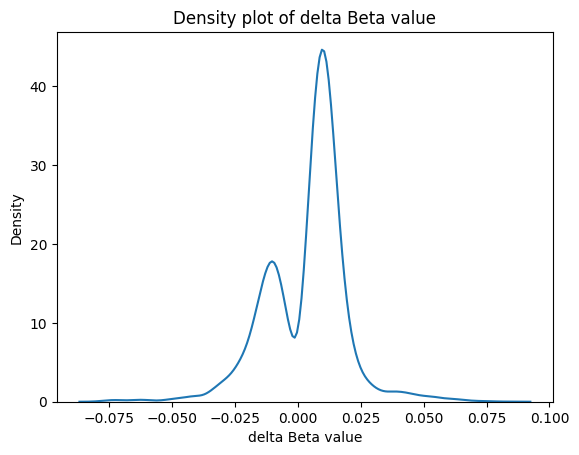

In [3]:
def get_distribution(input_path):
    data = pd.read_csv(input_path)
    sns.kdeplot(data['dbeta'])
    plt.xlabel('delta Beta value')
    plt.title('Density plot of delta Beta value')

get_distribution(input_path) # example path

#### 查看normal/tumor分布

In [4]:
x = pd.read_csv(f"{input_file_path}/all_beta_normalized.csv")
x = x.iloc[:,1::]
X = [x.iloc[:, i].values.flatten().tolist() for i in range(len(x.columns))]

normal_num = 
tumor_num = len(x.columns) - normal_num
y = [ (1 if i < tumor_num else 0)  for i in range(len(x.columns))]
# y = [ (0 if i < normal_num else 1)  for i in range(len(x.columns))]

In [5]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

def plot_pca_3d(elev, azim):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis')
    legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
    ax.add_artist(legend1)
    ax.set_title('PCA of Iris Dataset')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')

    ax.view_init(elev=elev, azim=azim)
    plt.show()

interact(plot_pca_3d, elev=widgets.FloatSlider(min=0, max=90, step=1, value=30), azim=widgets.FloatSlider(min=0, max=360, step=1, value=120))

interactive(children=(FloatSlider(value=30.0, description='elev', max=90.0, step=1.0), FloatSlider(value=120.0…

<function __main__.plot_pca_3d(elev, azim)>